In [48]:
import pandas as pd
import psycopg2
from psycopg2 import sql
import os
import geopandas as gpd

In [43]:
root = os.getcwd()

In [28]:
# create psycopg2 connection
conn = psycopg2.connect(dbname='tpwd-tests',
                       user='postgres', host='localhost', port='5432',
                       password='postgres')
cur = conn.cursor()

In [5]:
cur.execute("""
    SELECT DISTINCT taxonid
    FROM gbif_inverts_backbone
    WHERE taxonrank = %s AND taxonomicstatus = %s
""", ('species', 'accepted'))

unique_taxonids = cur.fetchall()

cur.close()
conn.close()

In [7]:
unique_taxonids = [row[0] for row in unique_taxonids]

In [16]:
len(unique_taxonids)

1690837

In [23]:
# Now. For each unique taxonid, we want to go through the observations table and analyze 
# all records that have a matching taxonkey or acceptedtaxonkey
taxonid_list_int = [int(taxonid) for taxonid in unique_taxonids]

<h3> Texas Shapefile </h3>

In [51]:
# Lat Longs within Texas Shape
texas_shape = os.path.join(root, "tx_boundaries", "tx.geojson")
texas_gdf = gpd.read_file(texas_shape)
texas_crs = texas_gdf.to_crs('EPSG:5070')

# Create a GeoDataFrame for Texas
texas_boundary = texas_gdf.geometry.union_all()

In [ ]:
# Now. For each unique taxonid, we want to go through the observations table and analyze 
# all records that have a matching taxonkey or acceptedtaxonkey

accepted_ids_and_rankings = []

for index, id in enumerate(taxonid_list_int):
    
    query = """
        SELECT * FROM gbif_observations
        WHERE CAST(REPLACE(taxonkey::TEXT, '.0', '') AS INT) = %s 
        OR CAST(REPLACE(acceptedtaxonkey::TEXT, '.0', '') AS INT) = %s"""
    
    cur.execute(query, (id, id))    
    
    occ_rows = cur.fetchall()
    occ_columns = [desc[0] for desc in cur.description]
    
    occ_df = pd.DataFrame(occ_rows, columns=occ_columns)
 
    gdf_points = gpd.GeoDataFrame(
        occ_df,
        geometry=gpd.points_from_xy(occ_df['decimallongitude'], occ_df['decimallatitude']),
        crs='EPSG:4326'
    )
    
    if occ_df.shape[0] == 0:
        accepted_ids_and_rankings.append([index, "DD"])
        continue
    
    range_ex_val = range_extent(gdf_points, texas_crs)
    
    if range_ex_val == 0:
        accepted_ids_and_rankings.append([index, "DD"])
        continue

    aoo_val = area_of_occupancy(gdf_points, texas_crs)
    
    if aoo_val == 0:
        accepted_ids_and_rankings.append([index, "DD"])
        continue
    
    rank = natureserve_ranking(occ_df.shape[0], range_ex_val, aoo_val)
    
    accepted_ids_and_rankings.append([index, rank])
    
    print(index, rank)

In [ ]:
# create psycopg2 connection
conn = psycopg2.connect(dbname='tpwd-tests',
                       user='postgres', host='localhost', port='5432',
                       password='postgres')
cur = conn.cursor()

query = """
    UPDATE gbif_inverts_backbone
    SET nsRank = %s
    WHERE taxonid = %s::TEXT
"""

id_rank_tuples = [(rank, taxonid) for taxonid, rank in id_rank_list]

cur.executemany(query, id_rank_tuples)

conn.commit()
cur.close()
conn.close()

In [ ]:
top_50 = sorted(accepted_ids_and_counts, key=lambda x: x[1], reverse = True)[:50]
print(top_50)

[[1341976, 35031], [5133088, 31228], [11701883, 30186], [1429340, 21113], [5714299, 20609], [5130514, 20009], [1925429, 18918], [1813415, 18259], [5141342, 17829], [1428054, 17267], [1340416, 16759], [1898286, 16389], [4989904, 16374], [5715127, 16005], [5171022, 15208], [1894342, 14639], [1937816, 12960], [5137694, 12514], [4302510, 12049], [2203611, 11154], [1898402, 10924], [1918988, 10757], [1918984, 10508], [1898416, 10492], [1427951, 10330], [4990191, 9994], [5129451, 9900], [4299370, 9789], [5035230, 9592], [1898431, 9084], [5137800, 8907], [1914465, 8712], [1048501, 8679], [1919939, 8612], [1920192, 8608], [1428276, 8596], [5173257, 8267], [1862841, 8262], [5051741, 8070], [1427825, 8024], [1310760, 7907], [1699044, 7879], [1950133, 7777], [1920621, 7618], [9579730, 7406], [4299368, 7232], [5051506, 7184], [1342324, 7068], [2008593, 6890], [5051321, 6736]]


In [45]:
total = sum(1 for _, count in accepted_ids_and_counts if count > 0)
print(total)

20594


<h2> Range Extent </h2>

In [94]:
def range_extent(gdf_points, crs_boundary):
    # Filter to good points
    valid_geoms = gdf_points[gdf_points.notna()]
    valid_geoms = valid_geoms[valid_geoms.is_valid & ~valid_geoms.is_empty]
    
    if valid_geoms.empty:
        return(0)
    
    # Get convex hull
    convex_hull = valid_geoms.union_all().convex_hull
    
    gdf_hull = gpd.GeoDataFrame(geometry=[convex_hull], crs='EPSG:4326')
    
    # Convert to non-degree projection
    projected_crs = 'EPSG:5070'
    gdf_hull_proj = gdf_hull.to_crs(projected_crs)
    
    # intersection at boundary
    clipped = gpd.overlay(gdf_hull_proj, crs_boundary, how='intersection')
    
    # area (in km2)
    area = clipped.geometry.area.sum() / 1e6 # m2 to km2
    
    return area

<h2> Area of Occupancy </h2>

In [76]:
from shapely.geometry import Point

def area_of_occupancy(gdf_points, crs_boundary):
    # Convert points to meters projection
    gdf_points = gdf_points.to_crs('EPSG:5070')
    
    # Clip points out of bounds
    gdf_within_boundary = gdf_points[gdf_points.geometry.within(crs_boundary.geometry.union_all())].copy()
    
    # Snap points to 2x2 km grid
    grid_size = 2000
    gdf_within_boundary['x_snap'] = (gdf_within_boundary.geometry.x // grid_size) * grid_size
    gdf_within_boundary['y_snap'] = (gdf_within_boundary.geometry.y // grid_size) * grid_size
    
    # Create a grid cell geometry for each snapped point
    gdf_within_boundary['grid_cell'] = gdf_within_boundary.apply(
        lambda row: Point(row.x_snap, row.y_snap).buffer(grid_size / 2, cap_style=3), axis=1
    )
    
    # Remove duplicate grid cells
    grid_cells = gpd.GeoDataFrame(geometry=gdf_within_boundary['grid_cell'].drop_duplicates(), crs=gdf_within_boundary.crs)
    
    # Get AOO
    area_per_cell_km2 = (grid_size / 1000) ** 2
    aoo_km2 = len(grid_cells) * area_per_cell_km2
    
    return(aoo_km2)
    

<h2> NatureServe Ranking </h2>

In [59]:
def natureserve_ranking(number_of_occurrences, range_extent, area_of_occupancy):

    points = 0

    # If all values are 0, species is data deficient. NatureServe doesn't actually have this ranking. This would be presumed extinct.
    if (number_of_occurrences == 0 and range_extent == 0 and area_of_occupancy == 0):
        return "DD"
    # If one of these values exists, all of them must
    elif (number_of_occurrences == 0 or range_extent == 0 or area_of_occupancy == 0):
        return "ERROR"

    if number_of_occurrences == 0: # NatureServe Z Value
        points += 0
    elif 0 < number_of_occurrences <= 5: # NatureServe A Value
        points += 0
    elif 5 < number_of_occurrences <= 20: # NatureServe B Value
        points += 1.38
    elif 20 < number_of_occurrences <= 80: # NatureServe C Value
        points += 2.75
    elif 80 < number_of_occurrences <= 300: # NatureServe D Value
        points += 4.13
    elif 300 < number_of_occurrences: # NatureServe E Value
        points += 5.50

    if area_of_occupancy == 0: # NatureServe Z Value
        points += 0
    elif 0 < area_of_occupancy <= 0.4: # NatureServe A Value
        points += 0
    elif 0.4 < area_of_occupancy <= 4: # NatureServe B Value
        points += 1.38
    elif 4 < area_of_occupancy <= 20: # NatureServe C Value
        points += 2.76
    elif 20 < area_of_occupancy <= 100: # NatureServe D Value
        points += 4.12
    elif 100 < area_of_occupancy <= 500: # NatureServe E Value
        points += 5.50
    elif 500 < area_of_occupancy <= 2000: # NatureServe F Value
        points += 6.88
    elif 2000 < area_of_occupancy <= 20000: # NatureServe G Value
        points += 8.26
    elif 20000 < area_of_occupancy <= 200000: # NatureServe H Value
        points += 9.62
    elif 200000 < area_of_occupancy: # NatureServe I Value
        points += 11

    if range_extent == 0: # NatureServe Z Value
        points += 0
    elif 0 < range_extent <= 100: # NatureServe A Value
        points += 0
    elif 100 < range_extent <= 250: # NatureServe B Value
        points += 0.79
    elif 250 < range_extent <= 1000: # NatureServe C Value
        points += 1.57
    elif 1000 < range_extent <= 5000: # NatureServe D Value
        points += 2.36
    elif 5000 < range_extent <= 20000: # NatureServe E Value
        points += 3.14
    elif 20000 < range_extent <= 200000: # NatureServe F Value
        points += 3.93
    elif 200000 < range_extent <= 2500000: # NatureServe G Value
        points += 4.71
    elif 25000000 < range_extent: # NatureServe H Value
        points += 5.50

    three_average_score = points / 4
    zero_range_rank = 0

    if three_average_score <= 1.5:
        zero_range_rank = 1
    elif three_average_score <= 2.5:
        zero_range_rank = 2
    elif three_average_score <= 3.5:
        zero_range_rank = 3
    elif three_average_score <= 4.5:
        zero_range_rank = 4
    elif three_average_score > 4.5:
        zero_range_rank = 5

    return (f'S{zero_range_rank}')
    

<h2> Flag Records that are in a State Area <h2>

In [114]:
import geodatasets

In [ ]:
# Load base maps and such
texas_parks = gpd.read_file(os.path.join(root, 'LWRCRP.gdb'), layer=0)
texas = texas_gdf

# Geodatasets Maps for Plotting
path = geodatasets.get_path('naturalearth.land')
world = gpd.read_file(path)


In [159]:
texas_parks.keys()

Index(['Owner', 'OwnerType', 'OwnerClass', 'OwnerPropName', 'Manager',
       'ManagerType', 'ManagerClass', 'ManagerPropName', 'ManagerPropNameAlt',
       'AcresCalc', 'DataSrcName', 'DataSrcID', 'GlobalID', 'LegendClass',
       'Shape_Length', 'Shape_Area', 'geometry'],
      dtype='object')

In [169]:
# Are there duplicates in OwnerPropName?

# Group by OwnerPropName and count unique IDs
dup_check = texas_parks.groupby('OwnerPropName')['GlobalID'].nunique()

# Filter to those with multiple IDs associated
print(dup_check[dup_check > 1].index)

Index(['', 'Addicks Reservoir', 'Airport Park', 'Alameda Park', 'Alamo Park',
       'Alexander Park', 'Almeda Park', 'American Legion Park', 'Amistad',
       'Amistad Park',
       ...
       'Windsor Park', 'Windwood Park', 'Winston Park', 'Wolf Creek Park',
       'Woodcreek Park', 'Woodland Hills Park', 'Woodland Park',
       'Woodland Springs Park', 'Wooldridge Park', 'Wright Patman'],
      dtype='object', name='OwnerPropName', length=573)


<Axes: >

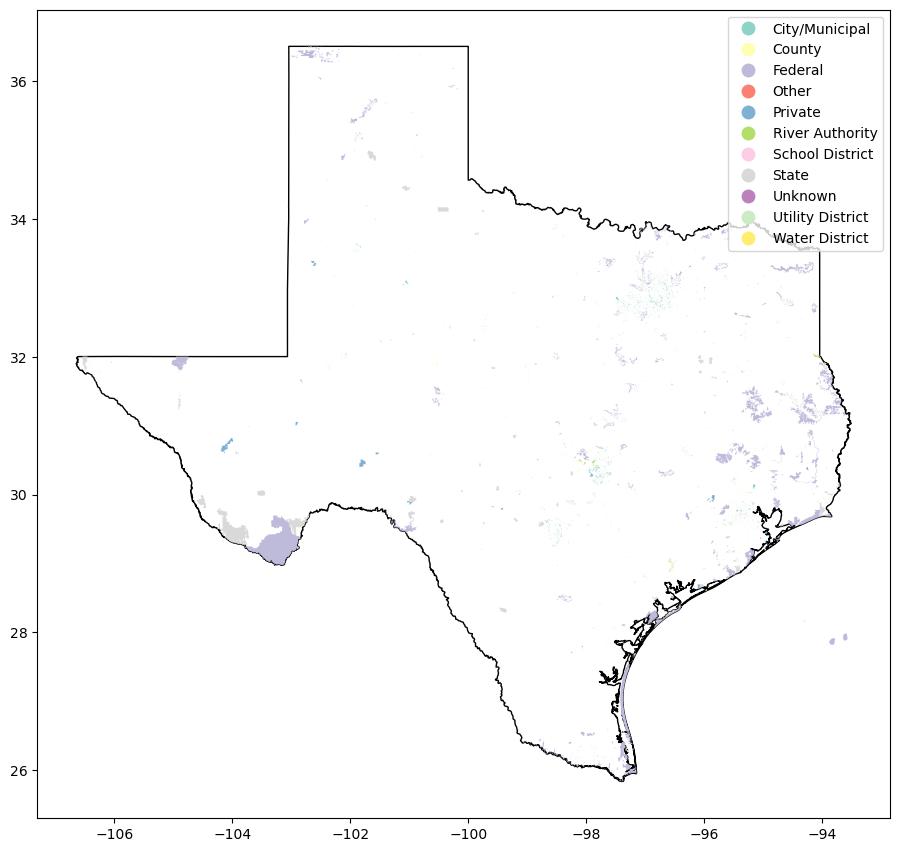

In [157]:
base = texas.plot(color='white', edgecolor='black', figsize=(11, 11))

texas_parks.plot(column='OwnerType', legend=True, ax=base, alpha=1, cmap='Set3')

<h3> Flag Observations with State Land Names <h3>

<h5> Create Texas Parks Table </h5>

In [ ]:
# Create table for Texas Parks 
# not sure what we'll need, let's just do 
    # Owner
    # OwnerType
    # OwnerClass
    # OwnerPropName
    # GlobalID
    # AcresCalc

# create psycopg2 connection
conn = psycopg2.connect(dbname='tpwd-tests',
                       user='postgres', host='localhost', port='5432',
                       password='postgres')
cur = conn.cursor()

# begin table creation query
query = 'DROP TABLE IF EXISTS ' + 'state_parks' + ';\n'
query += 'CREATE TABLE ' + 'state_parks' + '('

# create table columns usings columns from GBIF csv
query += 'owner' + ' TEXT,\n'
query += 'owner_type' + ' TEXT,\n'
query += 'owner_class' + ' TEXT,\n'
query += 'owner_prop_name' + ' TEXT,\n'
query += 'global_id' + ' UUID PRIMARY KEY,\n'
query += 'acres_calc' + ' DECIMAL(16, 8));'

cur.execute(query)

conn.commit()
cur.close()
conn.close()

<h5> Insert Texas Parks Data into Table </h5>

In [ ]:
# Insert Texas Parks Table into Database
from psycopg2.extras import execute_batch

# create psycopg2 connection
conn = psycopg2.connect(dbname='tpwd-tests',
                       user='postgres', host='localhost', port='5432',
                       password='postgres')
cur = conn.cursor()

# Map df column names to database column names
column_map = {
    'Owner': 'owner',
    'OwnerType': 'owner_type',
    'OwnerClass': 'owner_class',
    'OwnerPropName': 'owner_prop_name',
    'GlobalID': 'global_id',
    'AcresCalc': 'acres_calc'
}

# Rename df columns
parks_data_for_sql = texas_parks[list(column_map.keys())].rename(columns=column_map)

query = sql.SQL("""
        INSERT INTO state_parks ({})
        VALUES ({})
    """).format(sql.SQL(', ').join(map(sql.Identifier, parks_data_for_sql.columns)),
                sql.SQL(', ').join([sql.Placeholder()] * len(parks_data_for_sql.columns))
    )

# Create tuples for ~speed~
data_to_insert = parks_data_for_sql.itertuples(index=False, name=None)

execute_batch(cur, query, data_to_insert)

conn.commit()
cur.close()
conn.close()



<h5> Assign State Park Names to Observations in Observations Table </h5>

In [196]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
from psycopg2.extras import execute_batch

conn = psycopg2.connect(dbname='tpwd-tests',
                       user='postgres', 
                       host='localhost', 
                       port='5432',
                       password='postgres'
)

# Grab all observations
query = """
    SELECT gbifid, decimallatitude, decimallongitude
    FROM gbif_observations
"""
df = pd.read_sql_query(query, conn)

# Convert to gdf
geometry = [Point(xy) for xy in zip(df['decimallongitude'], df['decimallatitude'])]
obs_gdf = gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:4326')

# Load state park geometries 
texas_parks = gpd.read_file(os.path.join(root, 'LWRCRP.gdb'), layer=0).to_crs('EPSG:4326')

# Spatial join
joined = gpd.sjoin(
    obs_gdf,
    texas_parks[['GlobalID', 'geometry']],
    how='left',
    predicate='within'
)

# Create new 'state_park' column
joined['state_park'] = joined['GlobalID']
joined = joined[['gbifid', 'state_park']] # Reduce table
joined['state_park'] = joined['state_park'].where(pd.notnull(joined['state_park']), None) # Convert NaN to None    

conn.close()

C:\Users\mdw2685\AppData\Local\Temp\ipykernel_23572\3789783931.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


<h3> Insert these Values Back Into the Database </h3>

In [199]:
from psycopg2.extras import execute_batch
 
conn = psycopg2.connect(dbname='tpwd-tests',
                       user='postgres', 
                       host='localhost', 
                       port='5432',
                       password='postgres'
)
cur = conn.cursor()

# Grab all observations
query = """
    UPDATE gbif_observations
    SET state_park = %s
    WHERE gbifid = %s
"""

# Prepare joined table as list of tuples
rows_for_update = list(joined.itertuples(index=False, name=None))
# Swap row order for query
reordered_rows = [(row[1], row[0]) for row in rows_for_update]

# Batch update
execute_batch(cur, query, reordered_rows)

conn.commit()
cur.close()
conn.close()

In [ ]:
# QUERY TO GET S1 TAXA FROM BACKBONE AND MATCH THEM TO STATE PARKS
# THEN ORDER STATE PARKS BY HOW MANY S1 TAXA THEY CONTAIN, WITH COUNT